# Отчёт: Предсказание результата матча Dota 2 по первым 5 минутам игры

## Базовая подготовка данных

In [1]:
import pandas as pd
import numpy as np
from src.utils import out
from scipy import stats
from sklearn.preprocessing import StandardScaler
import datetime
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np
from joblib import dump, load
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
import seaborn as sns

class CList:
    def __init__(self, start, stop, step):
        self.start = start
        self.stop = stop
        self.step = step
    def __iter__(self):
        self.c = self.start
        return self
    def __next__(self):
        if self.c <= self.stop:
            x = self.c
            self.c += self.step
            return x
        else:
            raise StopIteration

Считать таблицу с признаками из файла.

In [2]:
data = pd.read_csv('./features.csv', index_col='match_id')

In [3]:
data.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


Удалить признаки связанные с итогами матча

In [4]:
columns_to_drop = ['duration', 'tower_status_radiant', 'tower_status_dire',
                       'barracks_status_radiant',
                       'barracks_status_dire']
data = data.drop(columns_to_drop, axis=1)

Проверить выборку на наличие пропусков

In [5]:
values_full = data.count()
rows_quantity = data.shape[0]
columns_with_empty = []
for column, length in values_full.iteritems():
    if rows_quantity - length > 0:
        columns_with_empty.append(column)
columns_with_empty

['first_blood_time',
 'first_blood_team',
 'first_blood_player1',
 'first_blood_player2',
 'radiant_bottle_time',
 'radiant_courier_time',
 'radiant_flying_courier_time',
 'radiant_first_ward_time',
 'dire_bottle_time',
 'dire_courier_time',
 'dire_flying_courier_time',
 'dire_first_ward_time']

Данные колонки имеют пропущенные значения, по скольку не всегда описуемые данными колонками события происходят в первые 5 минут игры.

Заменить пропуски на 0

In [6]:
value = 0
data[columns_with_empty] = data[columns_with_empty].fillna(value=value, inplace=False)

Отделить колонку с целевой переменной.
X - фичи;
y - целевая переменная, колонка 'radiant_win'

In [7]:
y = data[["radiant_win"]].values.ravel()
X = data.drop(["radiant_win"], axis=1).values

## Визуализация данных

<IPython.core.display.Javascript object>


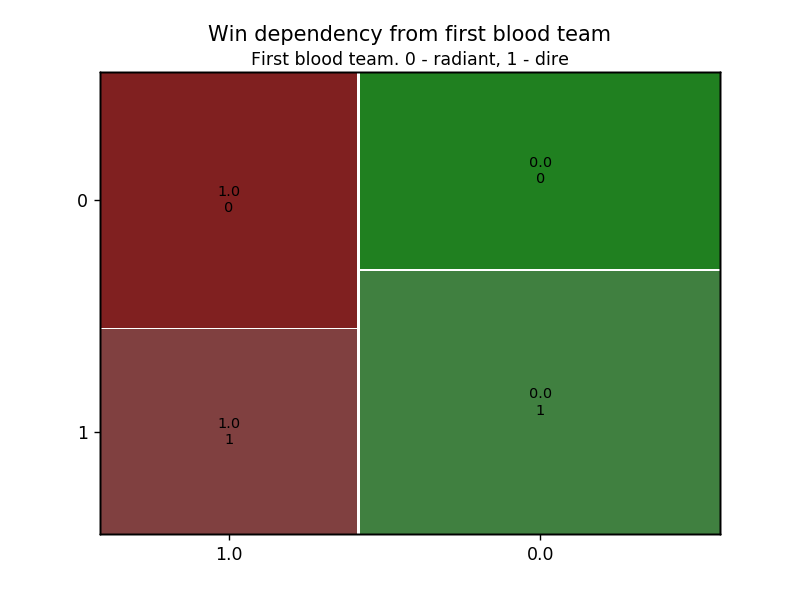

In [8]:
mosaic(data, ['first_blood_team', 'radiant_win'])
plt.xlabel('First blood team. 0 - radiant, 1 - dire')
plt.title('Win dependency from first blood team')
plt.show()

Как можно видеть, комманда, совершившая первую кровь, побеждает чаще.

## Подход 1. Градиентный бустинг "в лоб"

Фиксировать генератор разбиений по 5 блокам

In [9]:
kf = KFold(n_splits=5, shuffle=True)

Оценить качество градиентного бустинга при разном колличестве деревьев

In [10]:
trees = [10, 20, 30, 40]
qualities_gb = []
for i in trees:
    start_time = datetime.datetime.now()
    clf = GradientBoostingClassifier(n_estimators=i)
    qualities_n_estimators = []
    for train_index, test_index in kf.split(X):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = clf.fit(x_train, y_train)
        predictions = clf.predict_proba(x_test)[:, 1]
        qualities_n_estimators.append(roc_auc_score(y_test, predictions))
    mean_quality = np.mean(qualities_n_estimators)
    qualities_gb.append(mean_quality)
    print("Trees quantity: " + str(i))
    print('Time:', datetime.datetime.now() - start_time)
    print("Quality AUC-ROC: " + str(mean_quality))
    print('-')
max_q_gb = max(qualities_gb)
trees_n = trees[qualities_gb.index(max_q_gb)]
print("Best quality:", max_q_gb)
print("On trees number:", trees_n)

Trees quantity: 10
Time: 0:00:34.006707
Quality AUC-ROC: 0.6653593800090081
-
Trees quantity: 20
Time: 0:01:03.577704
Quality AUC-ROC: 0.6823241659039779
-
Trees quantity: 30
Time: 0:01:34.684461
Quality AUC-ROC: 0.6899437447556289
-
Trees quantity: 40
Time: 0:02:04.842932
Quality AUC-ROC: 0.6944971989733265
-
Best quality: 0.6944971989733265
On trees number: 40


<IPython.core.display.Javascript object>


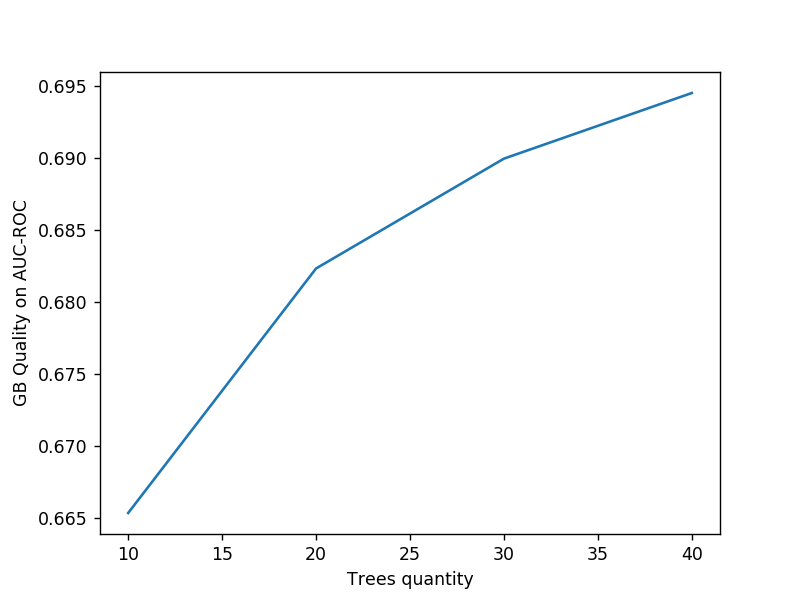

In [11]:
plt.figure()
plt.plot(trees, qualities_gb)
plt.xlabel('Trees quantity')
plt.ylabel('GB Quality on AUC-ROC')
plt.show()

Длительность кросс-валидации для градиентного бустинга с 30 деревьями: 0:01:34.684461
Качество по AUC - ROC: 0.6899437447556289

В градиентном бустинге имеет смысл использовать больше 30 деревьев, так как увелечение колличества деревьев даёт прирост качества.

Для ускорения обучения можно:
1. Уменьшение максимальной глубины деревьев (параметр max_depth)
2. Использование случайно выбранной подбвыборки для обучения и кросс-валидации
3. Удаление столбцов, feature_importance которых равняется 0 при текущем колличестве деревьев.

## Подход 2. Логистическая регрессия

In [12]:
x_data = data.drop(["radiant_win"], axis=1)

Необходимо масштабировать данные, так как логистическая регрессия чувствительна к выбросам

In [13]:
def scale_data(X_train):
    scaler = StandardScaler()
    scaler.fit(X_train)
    StandardScaler(copy=True, with_mean=True, with_std=True)
    X_train = scaler.transform(X_train)
    return X_train

X_scaled = scale_data(X)
X_scaled

array([[-2.54436416,  1.54068827, -1.24422828, ..., -0.55115386,
         1.84600409, -1.12149424],
       [-2.54045236, -0.92779756, -0.29225805, ...,  0.67817009,
         0.43778816,  0.04394713],
       [-2.53923104,  1.54068827, -0.5686365 , ...,  0.67817009,
         0.43778816,  0.49028637],
       ...,
       [ 1.09874571, -0.57515673,  1.42743012, ...,  0.67817009,
         0.43778816, -0.20401912],
       [ 1.09895204, -0.57515673,  1.48884755, ...,  0.67817009,
         0.43778816, -0.87352799],
       [ 1.1026479 ,  1.54068827, -0.04658831, ..., -0.55115386,
        -0.97042777, -0.79913812]])

Код для подборки параметра С и получения лучшего качества вынесен в отдельные функции для удобства.

In [14]:
def process_lr(kf, X, y, c_list_iterator):
    qualities = []
    for i, c in enumerate(c_list_iterator):
        start_time = datetime.datetime.now()
        clf = LogisticRegression(penalty='l2', C=c, solver="lbfgs", max_iter=200)
        qualities_c = []
        for train_index, test_index in kf.split(X):
            x_train, x_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            clf = clf.fit(x_train, y_train)
            predictions = clf.predict_proba(x_test)[:, 1]
            qualities_c.append(roc_auc_score(y_test, predictions))

        mean_quality = round(np.mean(qualities_c), 5)
        qualities.append(mean_quality)

        # print("C: " + str(c))
        print('Time:', datetime.datetime.now() - start_time)
        # print("Quality AUC-ROC: " + str(mean_quality))
        # print("-")

    return qualities

def get_best_quality_c(qualities, start, step):
    max_q = max(qualities)
    best_c = (qualities.index(max_q) * step) + start
    return max_q, best_c

In [15]:
kf = KFold(n_splits=5, shuffle=True)
start, stop, step = 1, 4, 0.2
c_list_iterator = iter(CList(start, stop, step))

qualities = process_lr(kf, X_scaled, y, c_list_iterator)
max_q, best_c = get_best_quality_c(qualities, start, step)

print("Max quality: ", max_q)
print("Max quality C: ", best_c)

Time: 0:00:05.324054
Time: 0:00:05.373519
Time: 0:00:05.371038
Time: 0:00:05.610256
Time: 0:00:05.414819
Time: 0:00:05.551381
Time: 0:00:05.504484
Time: 0:00:05.491365
Time: 0:00:05.663207
Time: 0:00:05.224661
Time: 0:00:05.461563
Time: 0:00:05.415984
Time: 0:00:05.379343
Time: 0:00:05.269770
Time: 0:00:05.318700
Max quality:  0.71664
Max quality C:  3.6


Таким образом:
- Качество у логистической регрессии над всеми исходными признаками: 0.71664
- Выше качества градиентного бустинга на ~1%. Т.е логистическая лучше находит зависимости в текущих данных.
- Логистическая регрессия работает намного быстрее градиентного бустинга.

Попробовать удалить категориальные признаки, которые присутствуют в выборке и используются как числовые и провести кросс валидацию с подбором параметра на новой выборке:

In [16]:
# Удалить колонки с категориальными признаками
x_data_cat_dropped = x_data.drop(['lobby_type'], axis=1)
for i in range(1, 6):
    x_data_cat_dropped = x_data_cat_dropped.drop(["r" + str(i) + "_hero"], axis=1)
    x_data_cat_dropped = x_data_cat_dropped.drop(["d" + str(i) + "_hero"], axis=1)

In [17]:
# Масштабировать данные, провести кросс валидицаю с подбором параметра

X_cat_dropped_scaled = scale_data(x_data_cat_dropped.values)

qualities = process_lr(kf, X_cat_dropped_scaled, y, c_list_iterator)
max_q, best_c = get_best_quality_c(qualities, start, step)

print("Max quality: ", max_q)
print("Max quality C: ", best_c)

Time: 0:00:05.076574
Time: 0:00:05.016661
Time: 0:00:05.131639
Time: 0:00:04.910816
Time: 0:00:04.920304
Time: 0:00:05.189360
Time: 0:00:05.036924
Time: 0:00:05.078088
Time: 0:00:04.999501
Time: 0:00:05.086873
Time: 0:00:04.970429
Time: 0:00:05.192690
Time: 0:00:05.104876
Time: 0:00:05.052331
Time: 0:00:04.926564
Max quality:  0.71676
Max quality C:  1.0


Как можно видеть, качество не сильно изменилось (0.71664 C = 3.6 и 0.71676 C = 1.0). Это можно обосновать тем, что использование категориальных признаков в форме числовых не несёт в себе какой-либо важной информации для определения победителя (бессмысленно сравнивать id героев)

Колличество уникальных идентификаторов героев:

In [18]:
hero_columns = []
for i in range(1, 6):
    hero_columns.append("r" + str(i) + "_hero")
    hero_columns.append("d" + str(i) + "_hero")
unic_ids = pd.unique(data[hero_columns].values.ravel())
heroes_quantity = len(unic_ids)
print("Unic heroes:", sorted(unic_ids))
print("Unic heroes id quantity:", heroes_quantity)

Unic heroes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 109, 110, 112]
Unic heroes id quantity: 108


Можно видеть, что всего героев в доте 112, однако в выборке присутствуют не все.

Воспользуемся подходом "мешок слов" для кодирования информации о героях. Сформировать N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire.

In [19]:
def process_categorial(heroes_quantity, x_data, X):
    X_pick = np.zeros((x_data.shape[0], heroes_quantity + 4))

    for i, match_id in enumerate(x_data.index):
        for p in range(5):
            X_pick[i, x_data.loc[match_id, 'r%d_hero' % (p + 1)] - 1] = 1
            X_pick[i, x_data.loc[match_id, 'd%d_hero' % (p + 1)] - 1] = -1
    return np.hstack((X, X_pick))

X = process_categorial(heroes_quantity, x_data, X_scaled)

Провести кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации:


In [20]:
qualities = process_lr(kf, X, y, c_list_iterator)
max_q, best_c = get_best_quality_c(qualities, start, step)

print("Max quality: ", max_q)
print("Max quality C: ", best_c)

Time: 0:00:23.453169
Time: 0:00:22.277976
Time: 0:00:23.357566
Time: 0:00:23.272152
Time: 0:00:23.748687
Time: 0:00:23.077867
Time: 0:00:22.825290
Time: 0:00:21.687904
Time: 0:00:22.504709
Time: 0:00:21.818747
Time: 0:00:24.013322
Time: 0:00:23.801400
Time: 0:00:23.000691
Time: 0:00:23.948215
Time: 0:00:23.231415
Max quality:  0.75201
Max quality C:  1.0


Качество: 0.75201 при С = 1.0. После использование мешка слов качество заметно улучшилось. Это связано с тем, что комманда имеет больший шанс выйграть, если в ней присутствуют определенные герои.

Обучим и сохраним итоговую модель:

In [21]:
lr = LogisticRegression(penalty='l2', C=best_c, solver="lbfgs", max_iter=200)
for train_index, test_index in kf.split(X):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        lr = lr.fit(x_train, y_train)
dump(lr, "lr.joblib")


['lr.joblib']

## Проверка финальной модели

In [22]:
def prepare_test_data_lr():
    # Считать набор данных для теста
    data = pd.read_csv('./features_test.csv', index_col='match_id')
    # Заполнить пропущенные значения
    data[columns_with_empty] = data[columns_with_empty].fillna(value=0, inplace=False)
    # Масштабировать данные
    X_scaled = scale_data(data.values)
    # Подготовить категориальные данные
    X = process_categorial(108, data, X_scaled)
    return X, data

def test_lr(X, data):
    # Загрузить сохраненную модель логистической регрессии
    clf = load("lr.joblib")
    predictions_df = pd.DataFrame(clf.predict_proba(X))
    predictions_df.columns = ['dire_win', 'radiant_win']
    predictions_df.index = data.index
    print(predictions_df.head())
    print("Mean:\n", predictions_df.mean())
    print("Max prob. radiant win: ", max(predictions_df['radiant_win']))  
    print("Min prob. radiant win: ", min(predictions_df['radiant_win']))
    result = predictions_df.drop(['dire_win'], axis=1)
    result.to_csv('./result.csv')

In [23]:
X, data = prepare_test_data_lr()
test_lr(X, data)

          dire_win  radiant_win
match_id                       
6         0.174565     0.825435
7         0.248691     0.751309
10        0.791185     0.208815
13        0.150089     0.849911
16        0.767004     0.232996
Mean:
 dire_win       0.48297
radiant_win    0.51703
dtype: float64
Max prob. radiant win:  0.996411753836501
Min prob. radiant win:  0.008841665544808848


Максимальная вероятность победить у radiant: 0.996411753836501;
Минимальная вероятность победить у radiant: 0.008841665544808848;
Таким образом предсказания находятся на отрезке [0:1].
Также можно сделать вывод, что в среднем вероятность победы у radiant немного выше, чем у dire.